# MVP  Metis Deep Learning Projct

## Classifying Habitat Types Using Image Recognition

### Nat Goodby

The labeled images used for this project were downloaded from Kaggle [here](https://www.kaggle.com/datasets/puneet6060/intel-image-classification?datasetId=111880&sortBy=voteCount).

In [127]:
import pandas as pd
import numpy as np

In [144]:
# What version of Python do you have?
import sys
from tensorflow import keras
import sklearn
import tensorflow
print(f"Tensor Flow Version: {tensorflow.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sklearn.__version__}")
gpu = len(tensorflow.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.4.1
Keras Version: 2.4.0

Python 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]
Pandas 1.2.4
Scikit-Learn 0.24.1
GPU is NOT AVAILABLE


In [129]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
size = (224,224)
num_classes = len(class_names)

In [130]:
from tqdm import tqdm
import os
import cv2

def load_data(class_names):
    
    datasets = ['input/seg_train/seg_train', 'input/seg_val/seg_val']
    output = []
    
    # Iterate through training and test set folders
    for dataset in datasets:
        
        images = []
        labels = []
        folders = os.listdir(dataset)
        folders = [value for value in folders if value != ".DS_Store"]
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in folders:
            label = class_names_label[folder]
            
            # Iterate through each image in the folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, size) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [131]:
(train_images, train_labels), (test_images, test_labels) = load_data(class_names)

  3%|▎         | 64/2271 [00:00<00:03, 633.59it/s]

Loading input/seg_train/seg_train


 14%|█▎        | 64/474 [00:00<00:00, 636.18it/s]

Loading input/seg_val/seg_val


100%|██████████| 510/510 [00:00<00:00, 735.43it/s]


In [132]:
from sklearn.utils import shuffle  
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [133]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training images: {}".format(n_train))
print("Number of test images: {}".format(n_test))
print("Each image is of size: {}".format(size))
print("Shape of training data: {}".format(train_images.shape))
print("Shape of test data: {}".format(test_images.shape))

Number of training images: 14034
Number of test images: 3000
Each image is of size: (224, 224)
Shape of training data: (14034, 224, 224, 3)
Shape of test data: (3000, 224, 224, 3)


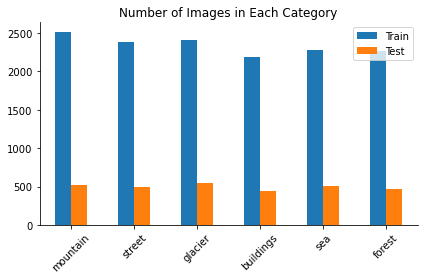

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

_, train_counts = np.unique(train_labels, return_counts=True)
_, val_counts = np.unique(test_labels, return_counts=True)

pd.DataFrame({'Train': train_counts,
                    'Test': val_counts}, 
             index=class_names
            ).plot.bar()
plt.title('Number of Images in Each Category')
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig('figures/class_balance.jpg')
plt.show()

Normalize each pixel value to between 0 and 1. Dividing by 255 because range of each RGB value is between 0 and 255.

In [135]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [136]:
import matplotlib.pyplot as plt
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f'Image #{index}: {class_names[labels[index]]}')
    plt.show()

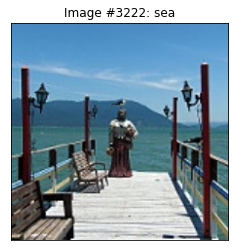

In [137]:
display_random_image(class_names, train_images, train_labels)

In [185]:
def display_examples(class_names, images, labels, title):
    """
        Display 25 images from the images array
    """
    
    fig = plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.savefig(title)
    plt.show()

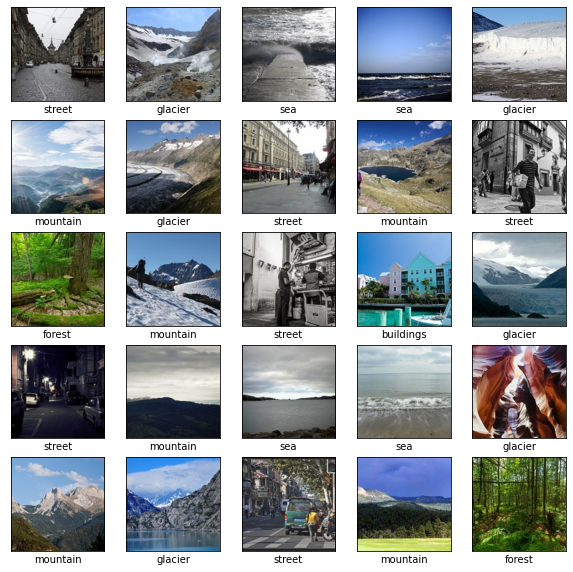

In [186]:
display_examples(class_names, train_images, train_labels, 'figures/sample_images.jpg')

# Baseline CNN model

In [146]:
from tensorflow.keras.models import load_model
baseline_model = load_model('models/baseline/baseline_cnn.07-0.77.hdf5')

In [235]:
len(baseline_model.layers)

7

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
baseline_model = keras.Sequential([
    layers.Conv2D(10, (3, 3), activation = 'relu', padding = 'same', input_shape = (224,224,3)), 
    layers.MaxPooling2D(2,2),
    layers.Conv2D(10, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(20, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [147]:
baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 10)      280       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 10)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 10)      910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 31360)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                627220    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

In [ ]:
baseline_model.compile(optimizer = 'adam', loss = 'cateogrical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
baseline = baseline_model.fit(train_images, train_labels, batch_size=64, epochs=10, verbose=1, 
                    validation_split = 0.2,
                   callbacks=[
           ModelCheckpoint(
               'models/baseline/baseline_cnn.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])

In [148]:
from sklearn.metrics import accuracy_score
baseline_preds = np.argmax(baseline_model.predict(test_images), axis=1)
accuracy_score(test_labels, baseline_preds)

0.735

In [149]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the cnn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
    plt.tight_layout()

In [150]:
plot_accuracy_loss(baseline)

NameError: name 'baseline' is not defined

In [200]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def cm(test_labels, preds, class_names, title):
    cm = confusion_matrix(test_labels, preds)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, 
               annot_kws={"size": 10}, 
               xticklabels=class_names, 
               yticklabels=class_names, ax = ax)
    plt.savefig("figures/{}.jpg".format(title))
    plt.show()

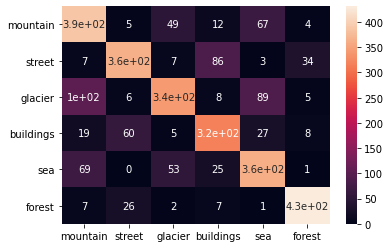

In [201]:
cm(test_labels, baseline_preds, class_names, 'Baseline Model Confusion Matrix')

# Transfer learning using the MobileNetV2 weights

In [236]:
vgg_model = load_model('models/vgg/vgg_best_model.01-0.36.hdf5')

In [5]:
from tensorflow.keras.applications import mobilenet_v2
vgg = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [6]:
# Freeze convolutional layers
for layer in vgg.layers:
    layer.trainable = False   

In [7]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
# Establish new fully connected block
x = vgg.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(100, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
vgg_predictions = Dense(num_classes, activation='softmax')(x)

In [12]:
from tensorflow.keras.models import Model
vgg_model = Model(inputs=vgg.input, outputs=vgg_predictions)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [156]:
vgg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
epochs = 500
batch_size = 64
es = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
mc = ModelCheckpoint('models/vgg/vgg_best_model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True, verbose=1)
y_train_cat = to_categorical(train_labels)
hist_vgg = vgg_model.fit(train_images, y_train_cat, batch_size=batch_size, epochs=epochs , verbose=1, 
                    validation_split = 0.2,
          callbacks=[mc, es])

In [157]:
plot_accuracy_loss(hist_vgg)

NameError: name 'hist_vgg' is not defined

In [158]:
vgg_preds = np.argmax(vgg_model.predict(test_images), axis=1)
accuracy_score(test_labels, vgg_preds)

0.8853333333333333

# Fine tune the MobileNet model

In [160]:
vgg_model = load_model('models/tuned_vgg/vgg_tuned_model.10-0.60.hdf5')

In [ ]:
vgg.trainable = True # unfreeze the base model
vgg_model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-5),  # very low learning rate
              loss='cateogrical_crossentropy', metrics=['accuracy'])

# train end-to-end being careful of overfitting (i.e. low patience)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)
mc = ModelCheckpoint('models/tuned_vgg/vgg_tuned_model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True, verbose=1)
tuned_hist = vgg_model.fit(train_images, y_train_cat, batch_size=batch_size, epochs=10 , verbose=1, 
                    validation_split = 0.2,
          callbacks=[mc, es])

In [ ]:
plot_accuracy_loss(tuned_hist)

In [161]:
tuned_preds = np.argmax(vgg_model.predict(test_images), axis=1)
accuracy_score(test_labels, tuned_preds)

0.8976666666666666

# Try image augmentation and see if it can improve the model

In [162]:
vgg_model = load_model('models/image_augmentation/image_augmentation_model.06-0.28.hdf5')

In [163]:
vgg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'input/seg_train/seg_train',
        target_size=size, 
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True) 

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'input/seg_val/seg_val',
        target_size=size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [14]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# vgg.trainable = False
es = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
mc = ModelCheckpoint('models/image_augmentation_model.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True, verbose=1)
vgg_model.compile(optimizer='adam', 
              loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size,
        callbacks = [mc, es]
)

Epoch 1/50
125/125 [==============================] - 60s 458ms/step - loss: 1.6141 - accuracy: 0.6879 - val_loss: 0.6013 - val_accuracy: 0.8550

Epoch 00001: val_loss improved from inf to 0.60127, saving model to models/image_augmentation_model.01-0.60.hdf5
Epoch 2/50
125/125 [==============================] - 61s 489ms/step - loss: 0.6445 - accuracy: 0.8371 - val_loss: 0.4511 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.60127 to 0.45114, saving model to models/image_augmentation_model.02-0.45.hdf5
Epoch 3/50
125/125 [==============================] - 60s 476ms/step - loss: 0.5781 - accuracy: 0.8250 - val_loss: 0.5127 - val_accuracy: 0.8500

Epoch 00003: val_loss did not improve from 0.45114
Epoch 4/50
125/125 [==============================] - 58s 467ms/step - loss: 0.5018 - accuracy: 0.8564 - val_loss: 0.3498 - val_accuracy: 0.8863

Epoch 00004: val_loss improved from 0.45114 to 0.34980, saving model to models/image_augmentation_model.04-0.35.hdf5
Epoch 5/50
125/125

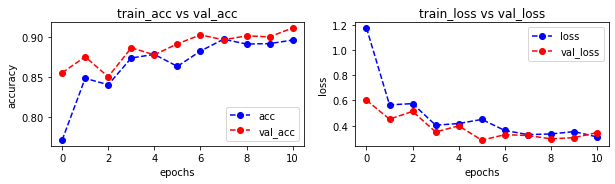

<Figure size 432x288 with 0 Axes>

In [18]:
plot_accuracy_loss(vgg_model.history)

In [165]:
Y_pred = vgg_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

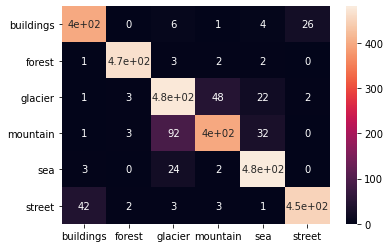

Classification Report
              precision    recall  f1-score   support

   buildings      0.893     0.915     0.904       437
      forest      0.983     0.983     0.983       474
     glacier      0.788     0.863     0.824       553
    mountain      0.876     0.756     0.812       525
         sea      0.887     0.943     0.914       510
      street      0.941     0.898     0.919       501

    accuracy                          0.890      3000
   macro avg      0.895     0.893     0.893      3000
weighted avg      0.892     0.890     0.890      3000



In [202]:
from sklearn.metrics import classification_report
cm(validation_generator.classes, y_pred, validation_generator.class_indices.keys(), 'Image Augmentation Confusion Matrix')
print('Classification Report')
target_names = validation_generator.class_indices.keys()
print(classification_report(validation_generator.classes, y_pred, target_names=target_names, digits=3))

# Predict unlabaled test images and see how the model performs

In [43]:
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory('input/seg_test',
                              classes=['seg_test'],
                              # don't generate labels
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              # use same size as in training
                              target_size=size)

preds = vgg_model.predict_generator(test_generator)
preds_idx = preds.argmax(axis=-1)

Found 7301 images belonging to 1 classes.


In [45]:
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
filenames_to_cls = list(zip(test_generator.filenames, preds_cls))

In [223]:
def print_test_images(idx1, idx2, filename):
    fig = plt.figure(figsize=(10,10))
    for i, (x,y) in enumerate(filenames_to_cls[idx1:idx2]):
        img = image.load_img("input/seg_test/{}".format(x), target_size=size)
        img = image.img_to_array(img)
        img = mobilenet_v2.preprocess_input(img)
        plt.subplot(1,4,i+1)
        plt.imshow(img)
        plt.xlabel(y, fontsize=16)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
    plt.tight_layout()
    plt.savefig("figures/{}".format(filename), bbox_inches='tight')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


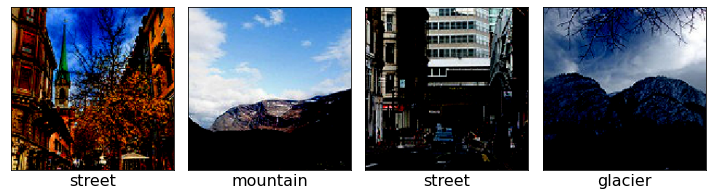

In [224]:
print_test_images(0,4,'test_images_1.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


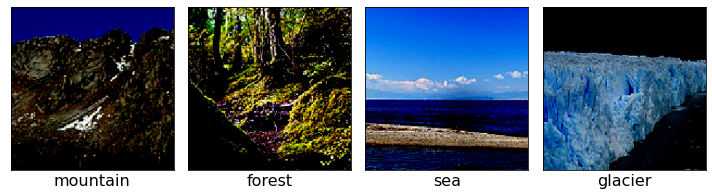

In [225]:
print_test_images(4,8,'test_images_2.jpg')

In [178]:
from tensorflow.keras.utils import plot_model
plot_model(vgg_model, "habitat_classifier_with_shape_info.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
